# Implementation of Hard-Margin Linear SVMs using CRNs

In the paper, we have shown how Hard-Margin Linear SVMs can be implemented using CRNs. Here, we show how to simulate the resulting CRN.

In [23]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#### Helper Functions

##### Loading Function
Takes the concentration of the source species and loads them into the target species

In [24]:
# laoding function
def load_function(y,t,a):
    c = y[0]
    dc_dt = -c + a
    return [ dc_dt]

def load_wrapper(from_species, to_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    from_species_concentration = species_concentrations[from_species][current_timestep - 1]
    to_species_concentration = species_concentrations[to_species][current_timestep - 1]

    y0 = [to_species_concentration]
    t = np.linspace(current_timestep, current_timestep+1, 2) # 2 steps
    
    sol = odeint(load_function, y0, t, args=(from_species_concentration,))

    threshold_loading = 1e-4

    if np.abs(sol[1][0] - to_species_concentration) > threshold_loading: # to ensure update only happens when substantial #review
        species_concentrations_current_timestep[to_species] = sol[1][0] # only value of to_species is updated

    return species_concentrations_current_timestep



##### Multiplication Function
Takes the concentration of source species and does the product of the concentrations of the species.

In [25]:
# multiplication function
def product_f(y,t,multiplicand_species_concentrations):
    c = y[0]

    dc_dt = 0

    temp = 1
    for idx, multiplicand in enumerate(multiplicand_species_concentrations):
        temp  = temp * multiplicand
    
    dc_dt = -c + temp
    return [ dc_dt]

def product_wrapper(multiplicand_species, product, current_timestep, species_concentrations, species_concentrations_current_timestep):
    multiplicand_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in multiplicand_species])

    c = species_concentrations[product][current_timestep - 1]

    y0 = [c]
    t = np.linspace(current_timestep, current_timestep+1,2)
    
    sol = odeint(product_f, y0, t, args=(multiplicand_species_concentrations,))

    threshold_product = 1e-4

    if np.abs(c-sol[1][0])> threshold_product:
        species_concentrations_current_timestep[product] = sol[1][0]

    return species_concentrations_current_timestep

##### Addition Function
Takes the concentration of the species and does the sum and loads them.

In [26]:
# sum function
def sum_f(y,t,additive_species_concentrations):
    c = y[0]
    temp =0
    for idx, additive in enumerate(additive_species_concentrations):
        temp = temp + additive
    dc_dt = -c + temp
    return [ dc_dt]

def sum_wrapper(additive_species, sum, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep -1
    additive_species_concentrations =  np.array([species_concentrations[species][current_timestep - 1] for species in additive_species])

    c = species_concentrations[sum][current_timestep-1]

    y0 = [c]
    t = np.linspace(current_timestep, current_timestep+1,2)
    
    sol = odeint(sum_f, y0, t, args=(additive_species_concentrations,))

    threshold_sum = 1e-4

    if np.abs(c-sol[1][0]) > threshold_sum:
        species_concentrations_current_timestep[sum] = sol[1][0]

    return species_concentrations_current_timestep

##### Comparison and Approximate Majority Function

Comparison Function: 
This function takes in 2 inputs (a,b), then computes r = b/(a+b) and puts them into bgta and 1-r into blta.

Approximate Majority Function:
Takes in 2 inputs, maps the greater one to sum of the species (here it is 1) and smaller one to 0.

In [27]:
# mapping function for comparison
def comparison_f(y, t, a, b):
    dydt = []
    bgta = y[0]
    blta = y[1]

    temp = b*blta - bgta*a
    dydt.append(temp)

    temp = bgta*a - b*blta
    dydt.append(temp)

    return dydt

def comparison_wrapper(species_a,species_b, b_gt_a, b_lt_a, current_timestep, species_concentrations, species_concentrations_current_timestep):

    a = species_concentrations[species_a][current_timestep-1]
    b = species_concentrations[species_b][current_timestep-1]
    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]

    y0 = [bgta, blta]
    t = np.linspace(current_timestep, current_timestep+1, 2)
    
    sol = odeint(comparison_f, y0, t, args=(a,b))

    threshold_comparison = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold_comparison:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold_comparison:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]

    return species_concentrations_current_timestep


In [28]:
# approximate majority for comparison
def approx_majority_f(y, t):
    kgtq = y[0]
    kltq = y[1]
    b_help = y[2]

    dydt = []
    
    temp =  - kgtq*kltq + kgtq *b_help
    dydt.append(temp)

    temp = kltq*b_help - kgtq*kltq
    dydt.append(temp)

    temp = 2* kgtq*kltq - kgtq*b_help - kltq*b_help
    dydt.append(temp)

    return dydt

def approx_majority_wrapper(b_gt_a, b_lt_a, helper_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    helper_s = species_concentrations[helper_species][current_timestep-1]

    y_0 = [bgta, blta, helper_s]

    t = np.linspace(current_timestep, current_timestep+1, 2)

    sol = odeint(approx_majority_f, y_0, t)

    threshold_am = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold_am:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold_am:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]
    if np.abs(helper_s - sol[:,2][-1]) > threshold_am:
        species_concentrations_current_timestep[helper_species] = sol[:,2][-1]

    return species_concentrations_current_timestep


##### Main Functions

In [29]:
# w_x = w*x module

# takes in arrays containing strings of the name of the species 
def product_wx(weights_array, x_array, product_array, current_timestep, species_concentrations, species_concentrations_current_timestep):
    num_indices = len(weights_array)
    for i in range(num_indices):
        species_concentrations_current_timestep = product_wrapper([weights_array[i] , x_array[i]] , product_array[i] , current_timestep, species_concentrations, species_concentrations_current_timestep)
    return species_concentrations_current_timestep


In [30]:
# summation of species

# takes in arrays containing strings of name of species
def summation_wx_b(additive_array, sum_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = sum_wrapper(additive_array, sum_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep
    

In [31]:
# Q = YP

def yp(yp, y, p, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = product_wrapper([y[0],p[0]], yp[0], current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wrapper([y[1],p[1]], yp[1], current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wrapper([y[0],p[1]], yp[2], current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = product_wrapper([y[1],p[0]], yp[3], current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep


In [32]:
# Q+ & Q-

def q(q, yp, K , current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = sum_wrapper([yp[0],yp[1]], q[0], current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper([yp[2],yp[3],K], q[1], current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [33]:
#  comparing Q+ and Q- +1
def comparing_q(q, qgtk, qltk, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = comparison_wrapper(q[1],q[0], qgtk, qltk, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [34]:
# applying approximate majority

def q_am(qgtk, qltk, helper_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = approx_majority_wrapper(qgtk, qltk, helper_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [35]:
def calculate_update_weights(weights, x_array, y_array, cost_always, cost_classification_1, cost_classification_2, current_timestep, species_concentrations, species_concentrations_current_timestep):
    lr = 'lr'
    const_temp  = 'ct'
    l = len(weights)

    for i in range(l):
        species_concentrations_current_timestep = product_wrapper([lr, const_temp, weights[int((len(weights) /2  + i )%len(weights))]], cost_always[i],  current_timestep, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper([lr, x_array[i], 'Q_lt_K', y_array[0] ], cost_classification_1[i],  current_timestep, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper([lr, x_array[int((len(x_array) /2  + i )%len(x_array))], 'Q_lt_K', y_array[1] ], cost_classification_2[i], current_timestep, species_concentrations, species_concentrations_current_timestep)

        
    return species_concentrations_current_timestep

In [36]:
def update_weights(weights, final_weights , cost_always, cost_classification_1, cost_classification_2,  current_timestep, species_concentrations, species_concentrations_current_timestep):

    l = len(weights)

    for i in range(l):
        species_concentrations_current_timestep = sum_wrapper([weights[i], cost_always[i], cost_classification_1[i] , cost_classification_2[i]], final_weights[i],  current_timestep, species_concentrations, species_concentrations_current_timestep)
        
    return species_concentrations_current_timestep

In [37]:
def dual_rail_encoding_arr(x):
    x_p = []
    x_n = []
    for i in x:
        p = []
        n = []

        for j in i:
            if j > 0:
                p.append(j)
                n.append(0)
            else:
                p.append(0)
                n.append(-j)
        x_p.append(p)
        x_n.append(n)
    return x_p, x_n

def dual_rail_encoding_num(x):
    x_p = []
    x_n = []

    for i in x:
        if i > 0:
            x_p.append(i)
            x_n.append(0)
        else:
            x_p.append(0)
            x_n.append(-i)
    return x_p, x_n


In [38]:
# Parameters
epochs = 500
lr = 0.0001 
time_step = 100
ct = 1/500

In [39]:
# Input and Output
X = np.array([
    [27.65, 15.65],
    [23.1 , 14.6 ],
    [23.5 , 15.2 ],
    [24.05, 14.9 ],
    [24.5 , 14.7 ],
    [14.15, 17.35],
    [14.3 , 16.8 ],
    [14.3 , 15.75],
    [14.75, 15.1 ],
    [15.35, 15.5 ]
])

y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])

X_p, X_n = dual_rail_encoding_arr(X)
Y_p, Y_n = dual_rail_encoding_num(y)

In [40]:
# defining the species concentrations dictionary



species_concentrations = {    

    # input species
    'x1_p': [X_p[0][0]],
    'x2_p': [X_p[0][1]],
    'x1_n': [X_n[0][0]],
    'x2_n': [X_n[0][1]],

    # weight species
    'w1_p': [1], 
    'w2_p': [1], 
    'w1_n': [0],
    'w2_n': [0],
    
    # product species
    'w1px1p_p': [0],
    'w2px2p_p': [0],
    'w1nx1n_p': [0],
    'w2nx2n_p': [0],
    'w1px1n_n': [0],
    'w2px2n_n': [0],
    'w1nx1p_n': [0],
    'w2nx2p_n': [0],

    # bias species
    'b_p': [0],
    'b_n': [0],

    # sum species
    'P_p': [0],
    'P_n': [0],

    # output species
    'y_p': [Y_p[0]],
    'y_n': [Y_n[0]],

    # yp species
    'ypPp_p': [0],
    'ynPn_p': [0],
    'ypPn_n': [0],
    'ynPp_n': [0],

    # Q species
    'Q_p': [0],
    'Q_n+K': [0],

    # K species
    'K': [1], 

    # qgtk, qltk & helper species
    'Q_gt_K': [0.5],
    'Q_lt_K': [0.5],
    'helper': [0],

    # lr and ct
    'lr': [lr],
    'ct': [ct],

    # cost always species : lr*ct* species
    'lr_ct_w1_n': [0],
    'lr_ct_w2_n': [0],
    'lr_ct_w1_p': [0],
    'lr_ct_w2_p': [0],

    # cost classification 1 species : lr*species*Q_lt_K* y_p
    'lr_Q_lt_K_y_p_x1_p': [0],
    'lr_Q_lt_K_y_p_x2_p': [0],
    'lr_Q_lt_K_y_p_x1_n': [0],
    'lr_Q_lt_K_y_p_x2_n': [0],


    # cost classification 2 species : lr*species_complement*Q_lt_K* y_n
    'lr_Q_lt_K_y_n_x1_n': [0],
    'lr_Q_lt_K_y_n_x2_n': [0],
    'lr_Q_lt_K_y_n_x1_p': [0],
    'lr_Q_lt_K_y_n_x2_p': [0],

    # cost of bias update
    'lr_yn_Q_lt_K': [0],
    'lr_yp_Q_lt_K': [0],

    # final weights
    'w1_p_final': [0],
    'w2_p_final': [0],
    'w1_n_final': [0],
    'w2_n_final': [0],

    # final bias
    'b_p_final': [0],
    'b_n_final': [0],
}



In [41]:
# defining the species list
weights_array = [
    'w1_p', 'w2_p',  'w1_n', 'w2_n', 
]

x_array = [
    'x1_p', 'x2_p', 'x1_n', 'x2_n'
]

weights_array_2 = [
    'w1_p', 'w2_p', 'w1_n', 'w2_n' , 'w1_p', 'w2_p', 'w1_n', 'w2_n'
]

x_array_2 = [
    'x1_p', 'x2_p', 'x1_n', 'x2_n', 'x1_n', 'x2_n',  'x1_p', 'x2_p'
]

product_array = [
    'w1px1p_p', 'w2px2p_p', 'w1nx1n_p', 'w2nx2n_p', 'w1px1n_n', 'w2px2n_n', 'w1nx1p_n', 'w2nx2p_n'
]

additive_array_p = [
    'w1px1p_p', 'w2px2p_p', 'w1nx1n_p', 'w2nx2n_p', 'b_p'
]

additive_array_n = [
    'w1px1n_n', 'w2px2n_n', 'w1nx1p_n', 'w2nx2p_n', 'b_n'
]

yp_array = [
    'ypPp_p', 'ynPn_p', 'ypPn_n', 'ynPp_n'
]

p_array = [
    'P_p', 'P_n' , 'P_n', 'P_p'
]

y_array = [
    'y_p', 'y_n'
]

y_array_2 = [
    'y_p', 'y_n', 'y_p', 'y_n'
]

q_array = [
    'Q_p', 'Q_n+K'
]

cost_always = [
    'lr_ct_w1_n', 'lr_ct_w2_n', 'lr_ct_w1_p', 'lr_ct_w2_p'
]

cost_classification_1 = [
    'lr_Q_lt_K_y_p_x1_p', 'lr_Q_lt_K_y_p_x2_p', 'lr_Q_lt_K_y_p_x1_n', 'lr_Q_lt_K_y_p_x2_n'
]


cost_classification_2 = [
    'lr_Q_lt_K_y_n_x1_n', 'lr_Q_lt_K_y_n_x2_n', 'lr_Q_lt_K_y_n_x1_p', 'lr_Q_lt_K_y_n_x2_p'
]

final_weights = [
    'w1_p_final', 'w2_p_final', 'w1_n_final', 'w2_n_final', 
]

final_bias = [
    'b_p_final', 'b_n_final'
]




In [42]:
# training loop
for e in range(epochs):
    t =0
    print(f'Epoch {e}', end = '\r')

    # defining the species concentrations at current timestep

    for i, x in enumerate(X):
        species_concentrations_current_timestep = {}
        x1_p = X_p[i][0]
        x2_p = X_p[i][1]
        x1_n = X_n[i][0]
        x2_n = X_n[i][1]
        y_p = Y_p[i]
        y_n = Y_n[i]

        species_concentrations_current_timestep['x1_p'] = x1_p
        species_concentrations_current_timestep['x2_p'] = x2_p
        species_concentrations_current_timestep['x1_n'] = x1_n
        species_concentrations_current_timestep['x2_n'] = x2_n
        species_concentrations_current_timestep['y_p'] = y_p
        species_concentrations_current_timestep['y_n'] = y_n


        # product wx
        species_concentrations_current_timestep = product_wx(weights_array_2, x_array_2, product_array, t, species_concentrations, species_concentrations_current_timestep)

        # sum wx + b = p
        species_concentrations_current_timestep = summation_wx_b(additive_array_p, 'P_p', t, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = summation_wx_b(additive_array_n, 'P_n', t, species_concentrations, species_concentrations_current_timestep)

        # yp
        species_concentrations_current_timestep = yp(yp_array, y_array_2, p_array, t, species_concentrations, species_concentrations_current_timestep)

        # Q 
        species_concentrations_current_timestep = q(q_array, yp_array, 'K', t, species_concentrations, species_concentrations_current_timestep)

        # Q+ - Q- > 1
        # comparing Q+ and Q- +1
        species_concentrations_current_timestep = comparing_q(q_array, 'Q_gt_K', 'Q_lt_K', t, species_concentrations, species_concentrations_current_timestep)

        # applying approximate majority
        species_concentrations_current_timestep = q_am('Q_gt_K', 'Q_lt_K', 'helper', t, species_concentrations, species_concentrations_current_timestep)

        # calculating the update weights
        species_concentrations_current_timestep = calculate_update_weights(weights_array, x_array, y_array, cost_always, cost_classification_1, cost_classification_2, t, species_concentrations, species_concentrations_current_timestep)

        # # calculating the update bias 
        species_concentrations_current_timestep = product_wrapper(['lr', 'y_n', 'Q_lt_K'], 'lr_yn_Q_lt_K', t, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper(['lr', 'y_p', 'Q_lt_K'], 'lr_yp_Q_lt_K', t, species_concentrations, species_concentrations_current_timestep)

        # updating the weights concentrations
        species_concentrations_current_timestep = update_weights(weights_array, final_weights , cost_always, cost_classification_1, cost_classification_2, t, species_concentrations, species_concentrations_current_timestep)

        # # updating the bias concentrations
        species_concentrations_current_timestep = sum_wrapper(['lr_yn_Q_lt_K', 'b_p' ], 'b_p_final', t, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = sum_wrapper(['lr_yp_Q_lt_K', 'b_n' ], 'b_n_final', t, species_concentrations, species_concentrations_current_timestep)

        # loading to weights
        for i in range(len(final_weights)):
            species_concentrations_current_timestep = load_wrapper(final_weights[i], weights_array[i], t, species_concentrations, species_concentrations_current_timestep)
        
        # # loading to bias
        species_concentrations_current_timestep = load_wrapper('b_p_final', 'b_p', t, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = load_wrapper('b_n_final', 'b_n', t, species_concentrations, species_concentrations_current_timestep)
        




    
        for species in species_concentrations:
            if species in species_concentrations_current_timestep:
                species_concentrations[species].append(species_concentrations_current_timestep[species])
            else:
                species_concentrations[species].append(species_concentrations[species][-1])

        # print(species_concentrations)
        

KeyboardInterrupt: 

In [21]:
print("Net Weights and Bias: ", species_concentrations['w1_p'][-1] - species_concentrations['w1_n'][-1], species_concentrations['w2_p'][-1] - species_concentrations['w2_n'][-1], species_concentrations['b_p'][-1] - species_concentrations['b_n'][-1])


Net Weights and Bias:  0.5014859083170158 0.5007013019885294 0


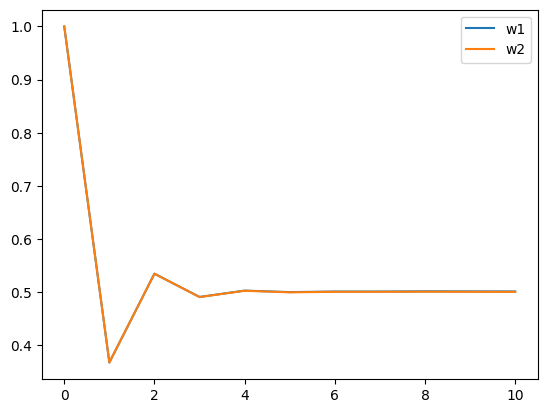

In [ ]:
# plot evolution of weights and bias
w1_net = np.array(species_concentrations['w1_p']) - np.array(species_concentrations['w1_n'])
w2_net = np.array(species_concentrations['w2_p']) - np.array(species_concentrations['w2_n'])
b_net = np.array(species_concentrations['b_p']) - np.array(species_concentrations['b_n'])

plt.plot(w1_net, label = 'w1')
plt.plot(w2_net, label = 'w2')
# plt.plot(b_net, label = 'b')
plt.legend()
plt.show()
